In [1]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt
import timeit
import os

In [3]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = 3000
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

# Compare optima from different plateaus 

In [8]:
directory = u'\\\\?\\R:\\home\\MEVeS\\MZ_paper_magic_detuning_(backtrack_bigbig_init)\\'

Raman_file_list = []

start = '_OD='
end = '_L'

OD_list = []

for file in os.listdir(directory):
    if '_MZ_enhanced' not in file:
        Raman_file_list.append(file)
        OD_list.append(float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.')))

In [9]:
ODs = np.array([5800, 6000, 7000])
indices = np.argmin(np.abs(np.array(OD_list)[:, None] - ODs[None, :]), axis=0)
actual_ODs = np.array(OD_list)[indices]
files = np.array(Raman_file_list)[indices]
files

array(['protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=5690_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6251_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6866_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz'],
      dtype='<U207')

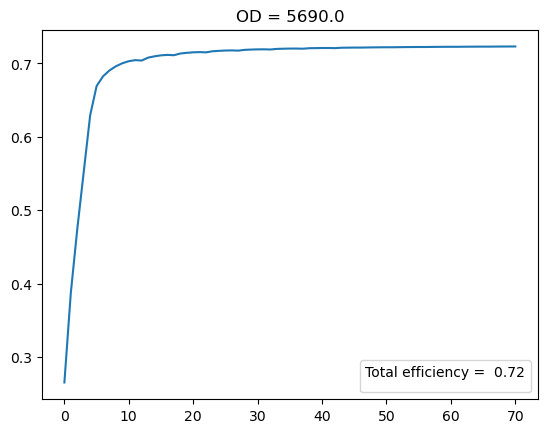

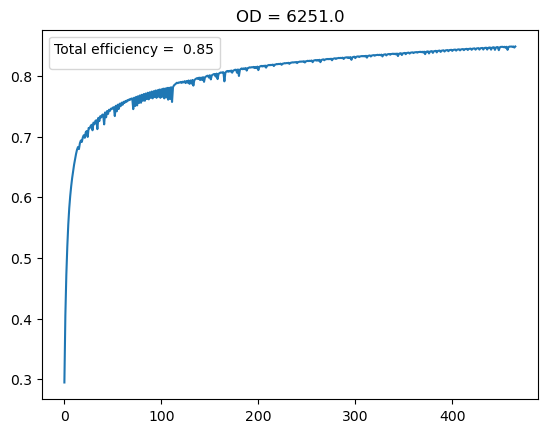

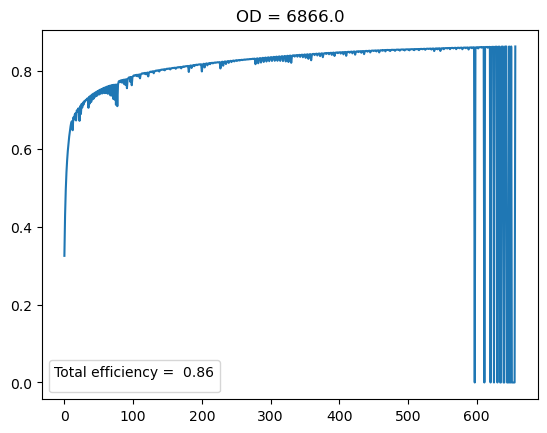

In [10]:
Controls = []
total_effs = []
for i, file in enumerate(files):
    with np.load(directory + file) as data:
        total_eff = data['total_eff_hist'][-1]
        plt.plot(data['total_eff_hist'])
        plt.title('OD = ' + str(actual_ODs[i]))
        plt.legend(handles=[], title=f'Total efficiency = {total_eff: .2f}')
        plt.show()
        total_effs.append(total_eff)
        Control = data['Control_best']
        Controls.append(Control)

In [11]:
start = 'e+00'
end = ']_T'
tend = float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.'))
m = Control.shape[1]
t = np.linspace(0, tend, m)

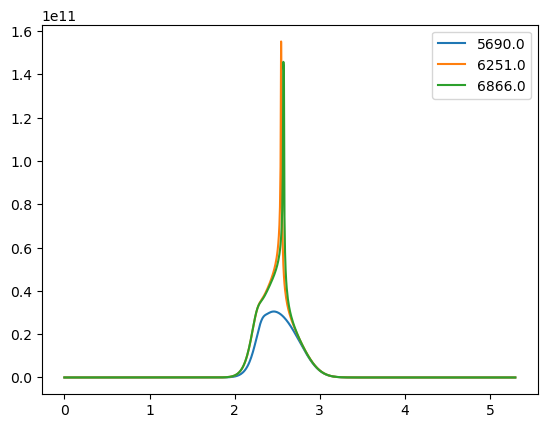

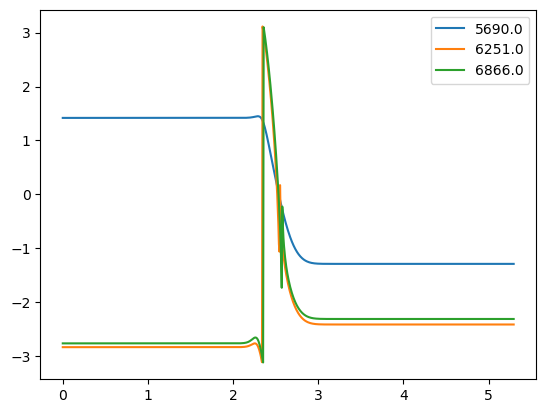

In [12]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.angle(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

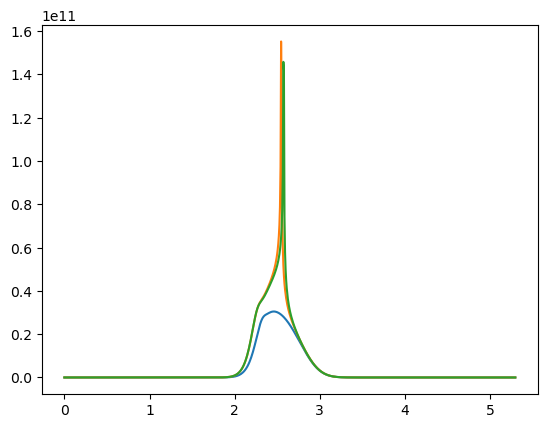

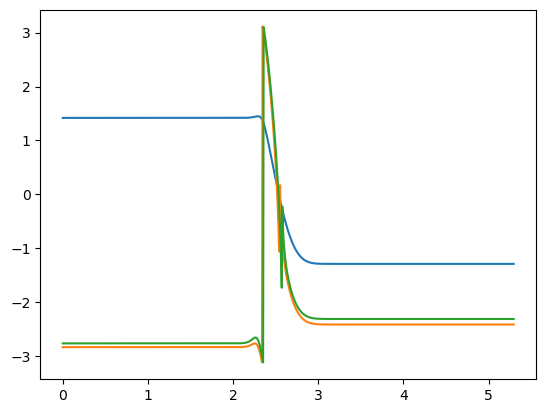

In [13]:
plt.plot(t*1e9, np.abs(Controls[0][0, :, 0]))
plt.plot(t*1e9, np.abs(Controls[1][0, :, 0]))
plt.plot(t*1e9, np.abs(Controls[2][0, :, 0]))
plt.show()

plt.plot(t*1e9, np.angle(Controls[0][0, :, 0]))
plt.plot(t*1e9, np.angle(Controls[1][0, :, 0]))
plt.plot(t*1e9, np.angle(Controls[2][0, :, 0]))
plt.show()

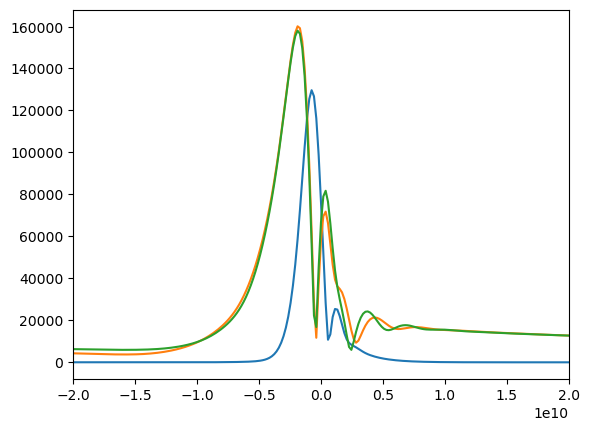

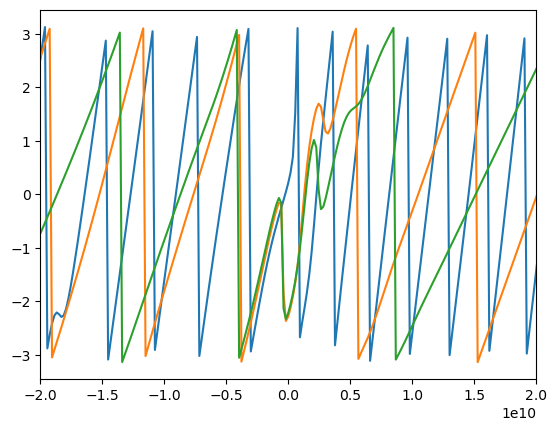

In [14]:
m = len(Controls[0][0, :, 0])
t = np.linspace(0, tend, m)

fControls = np.fft.fft(np.fft.ifftshift(np.array(Controls), axes=2)/sol.gamma, axis=2)
freq = np.fft.fftfreq(m, d = t[1]-t[0])

freq_shifted = np.fft.fftshift(freq)
fControls_shifted = np.fft.fftshift(fControls, axes=2)

plt.plot(freq_shifted, np.abs(fControls_shifted[0][0, :, 0]))
plt.plot(freq_shifted, np.abs(fControls_shifted[1][0, :, 0]))
plt.plot(freq_shifted, np.abs(fControls_shifted[2][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()

plt.plot(freq_shifted, np.angle(fControls_shifted[0][0, :, 0]))
plt.plot(freq_shifted, np.angle(fControls_shifted[1][0, :, 0]))
plt.plot(freq_shifted, np.angle(fControls_shifted[2][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()

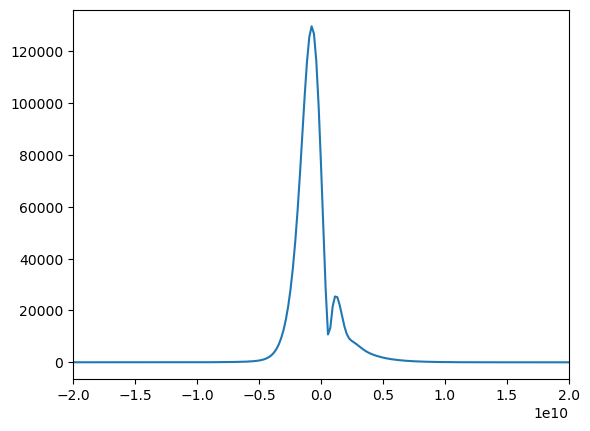

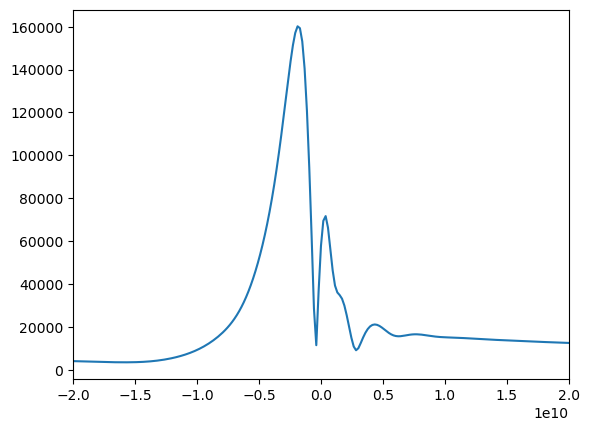

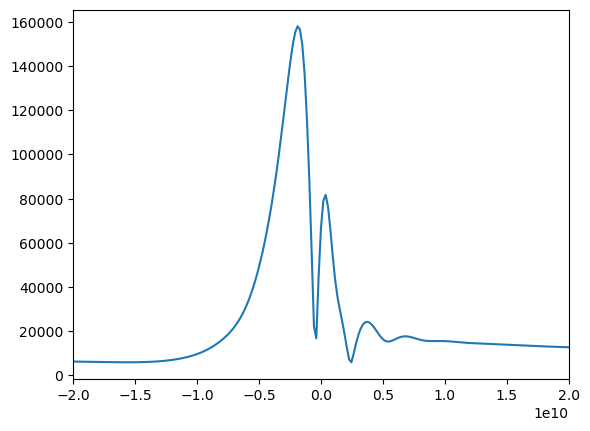

In [15]:
plt.plot(freq_shifted, np.abs(fControls_shifted[0][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()
plt.plot(freq_shifted, np.abs(fControls_shifted[1][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()
plt.plot(freq_shifted, np.abs(fControls_shifted[2][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()

# Check efficiency at higher m

In [ ]:
i = 0
print(total_effs[i])

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[i]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

Sout = sol.S[-1]

sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][1], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

print(sol.retrieval_efficiency(sol.E, 0, 0))


In [ ]:
i = 0
print(total_effs[i])

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[i]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 5000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

plt.plot(t*1e9, np.abs(Control_tzp(sol.tpoints, 0))[:, 0])
plt.xlim(1.8, 3.2)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

Sout = sol.S[-1]

sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][1], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

print(sol.retrieval_efficiency(sol.E, 0, 0))


In [11]:
i = 1
print(total_effs[i])

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[i]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

Sout = sol.S[-1]

sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][1], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

print(sol.retrieval_efficiency(sol.E, 0, 0))


0.8483590254713246
0.8483698416939066


0.8483590254713246


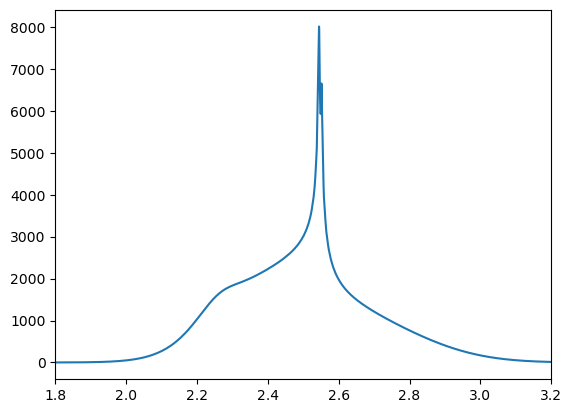

0.8486791558676703


In [12]:
i = 1
print(total_effs[i])

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[i]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 10000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

plt.plot(t*1e9, np.abs(Control_tzp(sol.tpoints, 0))[:, 0])
plt.xlim(1.8, 3.2)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

Sout = sol.S[-1]

sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][1], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

print(sol.retrieval_efficiency(sol.E, 0, 0))


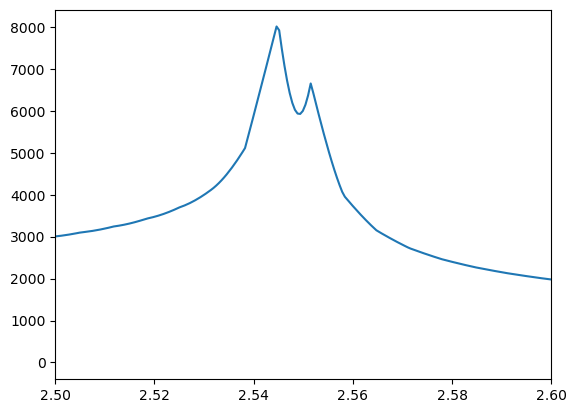

In [14]:
Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )
plt.plot(t*1e9, np.abs(Control_tzp(sol.tpoints, 0))[:, 0])
plt.xlim(2.5, 2.6)
plt.show()

In [ ]:
i = 2
print(total_effs[i])

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[i]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

Sout = sol.S[-1]

sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][1], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

print(sol.retrieval_efficiency(sol.E, 0, 0))


In [ ]:
i = 2
print(total_effs[i])

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[i]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 5000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][0], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

plt.plot(t*1e9, np.abs(Control_tzp(sol.tpoints, 0))[:, 0])
plt.xlim(1.8, 3.2)
plt.show()

sol.solve(Control_tzp, method='RK4-Ralston')

Sout = sol.S[-1]

sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.co_prop( Controls[i][1], t=np.linspace(0, tend, len(Controls[i][0, :, 0])) )

sol.solve(Control_tzp, method='RK4-Ralston')

print(sol.retrieval_efficiency(sol.E, 0, 0))


# Test higher OD opt at lower OD 

In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Controls[1][0], t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[1][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 100

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.01

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_storage, Control_inits, step_size, tol,
                                    adaptive_step_size=False)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



# Vary amplitude of higher OD optimum for lower OD

In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 1200
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

factor_list = np.linspace(0.3, 1.5, 10)

eff_list = []

for factor in factor_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.co_prop( factor*Controls[1][0], t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )

    sol.solve(Control_tzp, method='RK4-Ralston')

    Sout = sol.S[-1]

    sol = S.solver(atom, protocol, np.zeros((m, 2)), Sout, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_tzp = sol.co_prop( Controls[1][1], t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )

    sol.solve(Control_tzp, method='RK4-Ralston')

    eff_list.append(sol.retrieval_efficiency(sol.E, 0, 0))


In [ ]:
plt.plot(factor_list, eff_list)
plt.show()

# Two tone initial starting condition

In [16]:
directory = u'\\\\?\\R:\\home\\MEVeS\\MZ_paper_magic_detuning_(backtrack_bigbig_init)\\'

Raman_file_list = []

start = '_OD='
end = '_L'

OD_list = []

for file in os.listdir(directory):
    if '_MZ_enhanced' not in file:
        Raman_file_list.append(file)
        OD_list.append(float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.')))

In [17]:
ODs = np.array([5800, 6200])
indices = np.argmin(np.abs(np.array(OD_list)[:, None] - ODs[None, :]), axis=0)
actual_ODs = np.array(OD_list)[indices]
files = np.array(Raman_file_list)[indices]
files

array(['protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=5690_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6251_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz'],
      dtype='<U207')

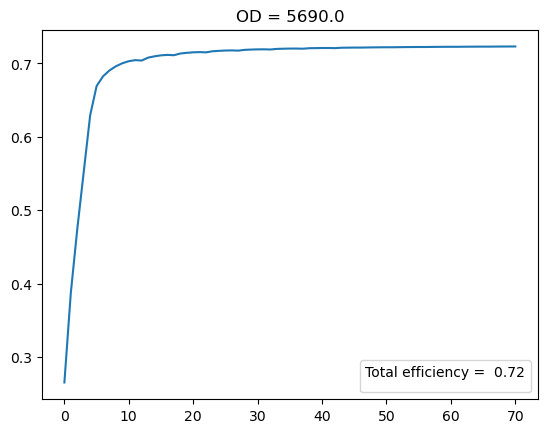

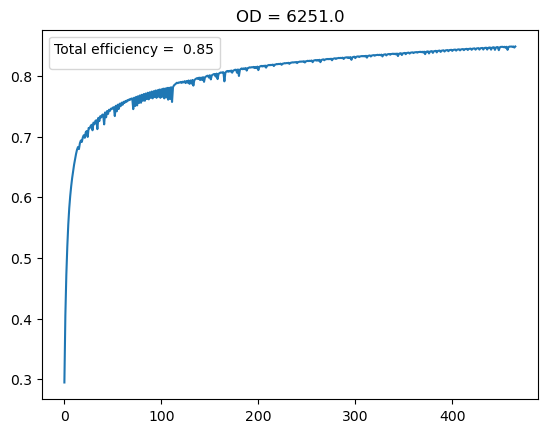

In [18]:
Controls = []
total_effs = []
for i, file in enumerate(files):
    with np.load(directory + file) as data:
        total_eff = data['total_eff_hist'][-1]
        plt.plot(data['total_eff_hist'])
        plt.title('OD = ' + str(actual_ODs[i]))
        plt.legend(handles=[], title=f'Total efficiency = {total_eff: .2f}')
        plt.show()
        total_effs.append(total_eff)
        Control = data['Control_best']
        Controls.append(Control)

In [19]:
start = 'e+00'
end = ']_T'
tend = float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.'))
m = Control.shape[1]
t = np.linspace(0, tend, m)

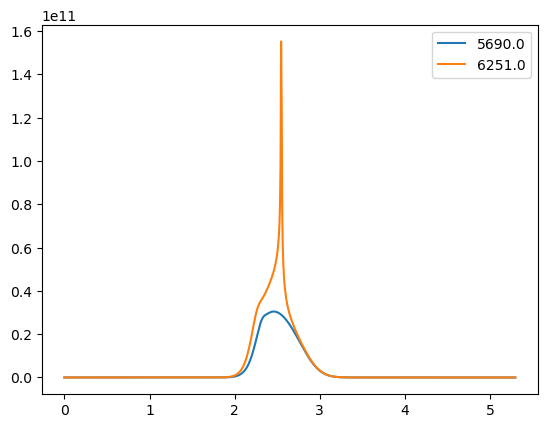

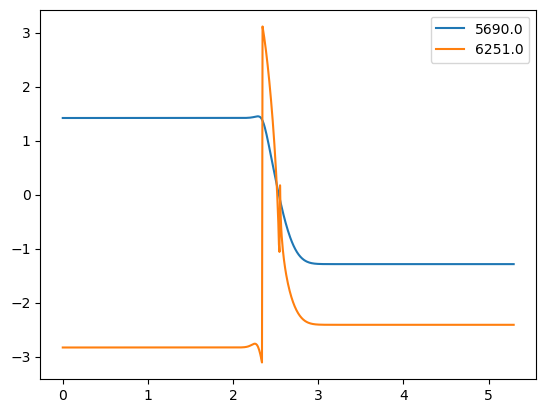

In [20]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.angle(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

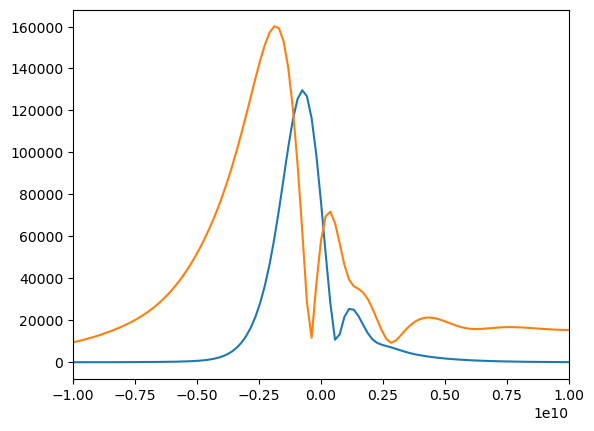

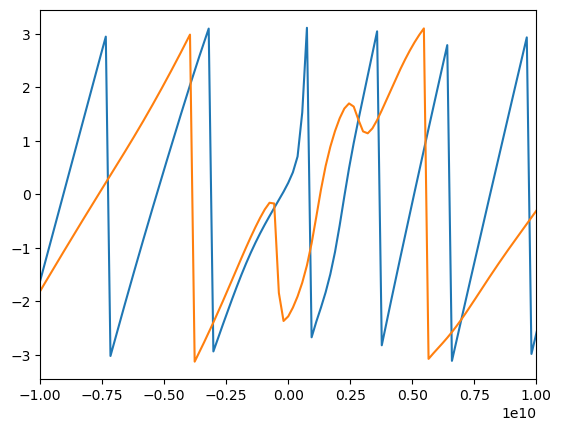

In [21]:
m = len(Controls[0][0, :, 0])
t = np.linspace(0, tend, m)

fControls = np.fft.fft(np.fft.ifftshift(np.array(Controls), axes=2)/sol.gamma, axis=2)
freq = np.fft.fftfreq(m, d = t[1]-t[0])

freq_shifted = np.fft.fftshift(freq)
fControls_shifted = np.fft.fftshift(fControls, axes=2)

plt.plot(freq_shifted, np.abs(fControls_shifted[0][0, :, 0]))
plt.plot(freq_shifted, np.abs(fControls_shifted[1][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

plt.plot(freq_shifted, np.angle(fControls_shifted[0][0, :, 0]))
plt.plot(freq_shifted, np.angle(fControls_shifted[1][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

### Make two tone

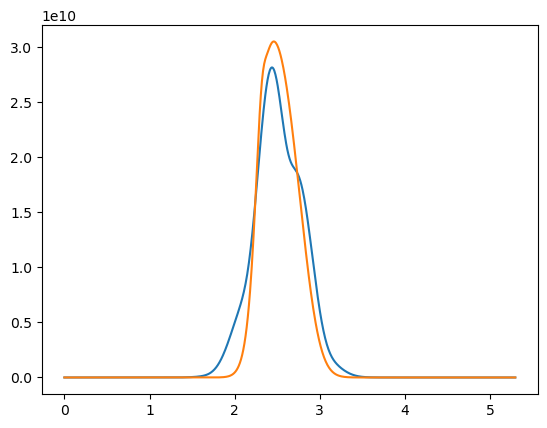

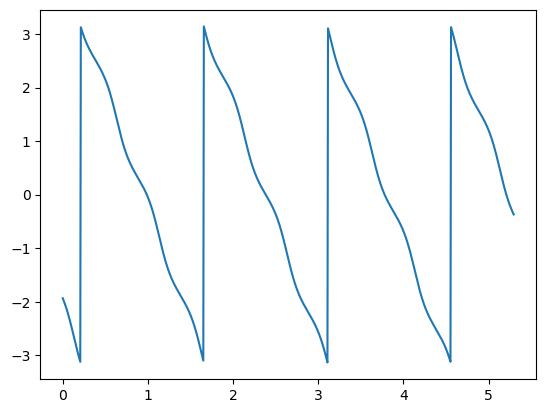

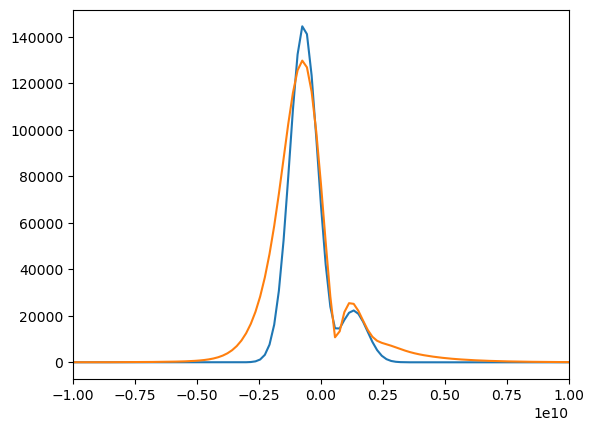

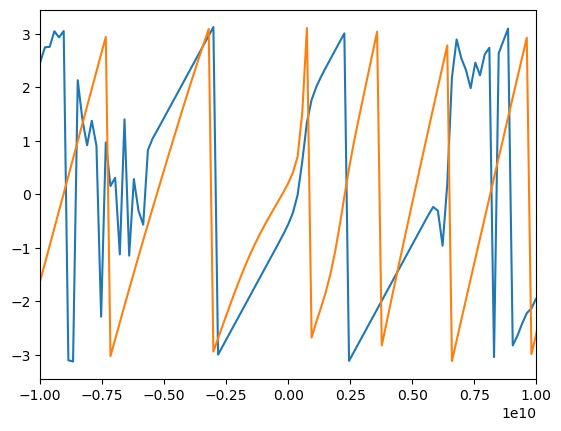

In [22]:
m = 800
t = np.linspace(0, tend, m)

Control = (S.gaussian(t, 0.95*t0, 1.5*tau, 3e10)*((13/15)*np.exp(1j*-(2*np.pi*700e6)*(t-0.9*t0)) + (2/15)*np.exp(1j*(2*np.pi*1.3e9)*(t - 0.9*t0))))[:, None] * control_pol[None, :]

plt.plot(t*1e9, np.abs(Control[:, 0]))
plt.plot(t*1e9, np.abs(Controls[0][0, :, 0]))
plt.show()

plt.plot(t*1e9, np.angle(Control[:, 0]))
plt.show()

fControl = np.fft.fft(np.fft.ifftshift(np.array(Control[:, 0]))/sol.gamma)
freq = np.fft.fftfreq(m, d = t[1]-t[0])

freq_shifted = np.fft.fftshift(freq)
fControl_shifted = np.fft.fftshift(fControl)

plt.plot(freq_shifted, np.abs(fControl_shifted))
plt.plot(freq_shifted, np.abs(fControls_shifted[0][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

plt.plot(freq_shifted, np.angle(fControl_shifted))
plt.plot(freq_shifted, np.angle(fControls_shifted[0][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

### No adaptive step

In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Control, t=np.linspace(0, tend, len(Control)) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[0][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 1000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.01

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_storage, Control_inits, step_size, tol,
                                    adaptive_step_size=False)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



### Wolfe

In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Control, t=np.linspace(0, tend, len(Control)) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[0][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 1000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.adapt_method = 'Wolfe'
opt.up_factor = 1.5
opt.down_factor = 0.5
opt.step_tol = 0.01
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_storage, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Control, t=np.linspace(0, tend, len(Control)) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[0][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 1000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.adapt_method = 'Wolfe'
opt.up_factor = 1.5
opt.down_factor = 0.5
opt.step_tol = 0.01
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



# Three tone initial starting condition

In [25]:
directory = u'\\\\?\\R:\\home\\MEVeS\\MZ_paper_magic_detuning_(backtrack_bigbig_init)\\'

Raman_file_list = []

start = '_OD='
end = '_L'

OD_list = []

for file in os.listdir(directory):
    if '_MZ_enhanced' not in file:
        Raman_file_list.append(file)
        OD_list.append(float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.')))

In [26]:
ODs = np.array([5800, 6200])
indices = np.argmin(np.abs(np.array(OD_list)[:, None] - ODs[None, :]), axis=0)
actual_ODs = np.array(OD_list)[indices]
files = np.array(Raman_file_list)[indices]
files

array(['protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=5690_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6251_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz'],
      dtype='<U207')

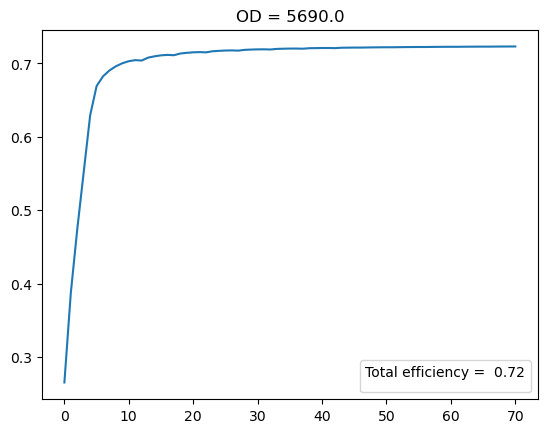

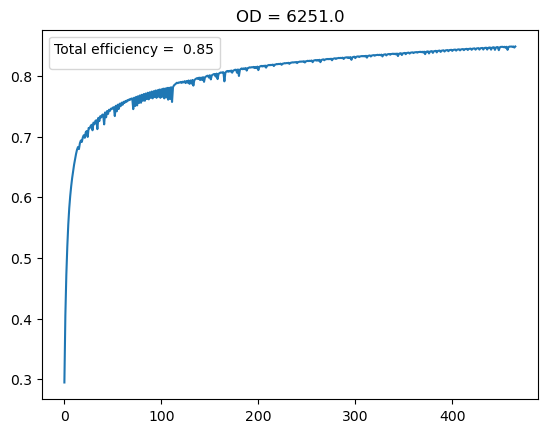

In [27]:
Controls = []
total_effs = []
for i, file in enumerate(files):
    with np.load(directory + file) as data:
        total_eff = data['total_eff_hist'][-1]
        plt.plot(data['total_eff_hist'])
        plt.title('OD = ' + str(actual_ODs[i]))
        plt.legend(handles=[], title=f'Total efficiency = {total_eff: .2f}')
        plt.show()
        total_effs.append(total_eff)
        Control = data['Control_best']
        Controls.append(Control)

In [28]:
start = 'e+00'
end = ']_T'
tend = float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.'))
m = Control.shape[1]
t = np.linspace(0, tend, m)

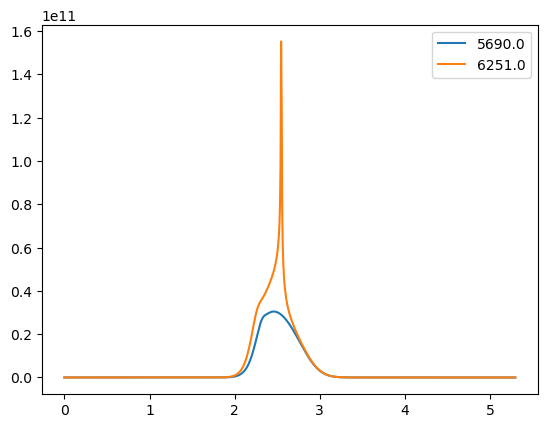

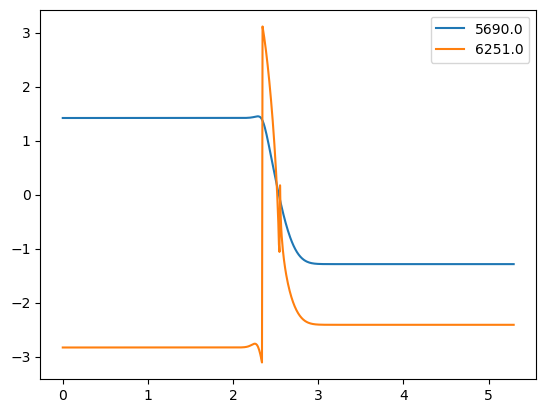

In [29]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.angle(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

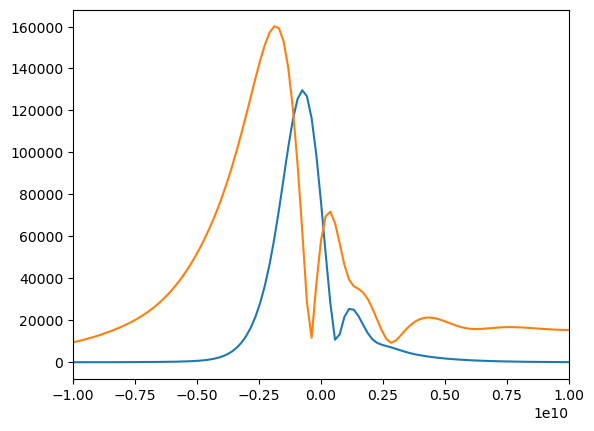

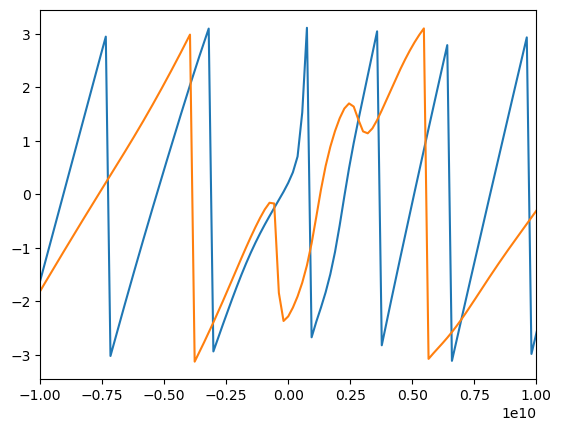

In [30]:
m = len(Controls[0][0, :, 0])
t = np.linspace(0, tend, m)

fControls = np.fft.fft(np.fft.ifftshift(np.array(Controls), axes=2)/sol.gamma, axis=2)
freq = np.fft.fftfreq(m, d = t[1]-t[0])

freq_shifted = np.fft.fftshift(freq)
fControls_shifted = np.fft.fftshift(fControls, axes=2)

plt.plot(freq_shifted, np.abs(fControls_shifted[0][0, :, 0]))
plt.plot(freq_shifted, np.abs(fControls_shifted[1][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

plt.plot(freq_shifted, np.angle(fControls_shifted[0][0, :, 0]))
plt.plot(freq_shifted, np.angle(fControls_shifted[1][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

### Make three tone

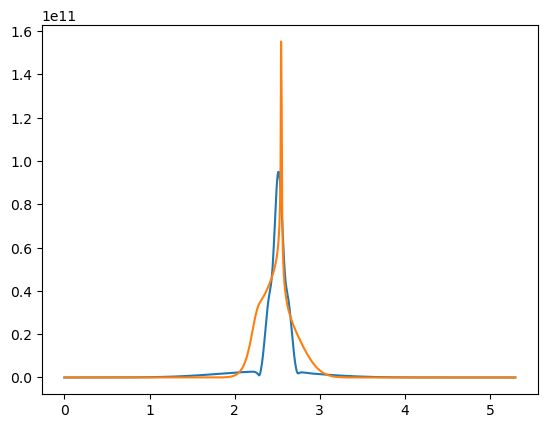

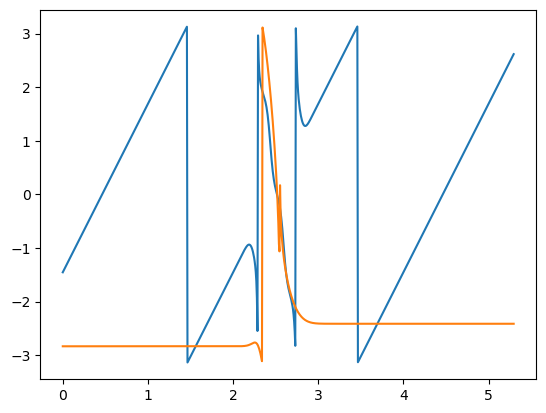

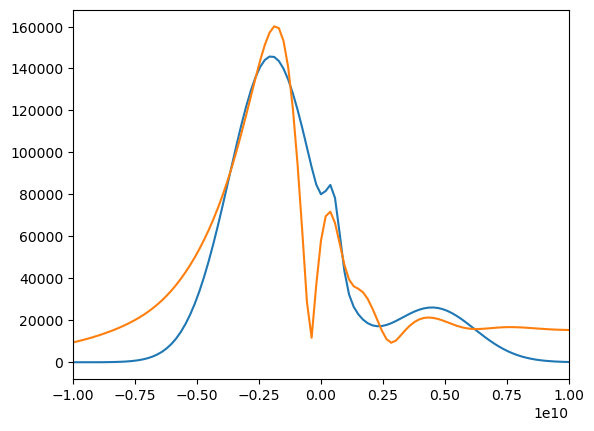

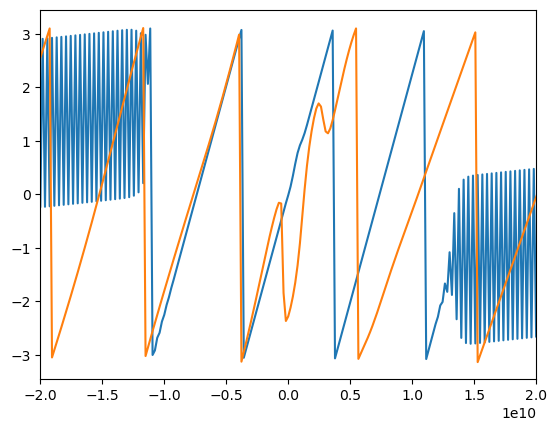

In [31]:
m = 800
t = np.linspace(0, tend, m)

Control = (S.gaussian(t, 0.95*t0, 0.5*tau, 7e10)*(28/25)*np.exp(1j*-(2*np.pi*2e9)*(t-0.95*t0)) 
            + S.gaussian(t, 0.9*t0, 3*tau, 7e10)*(1/25)*np.exp(1j*(2*np.pi*0.5e9)*(t - 0.93*t0))
            + S.gaussian(t, 0.95*t0, 0.5*tau, 7e10)*(5/25)*np.exp(1j*(2*np.pi*4.5e9)*(t - 0.95*t0)))[:, None] * control_pol[None, :]

plt.plot(t*1e9, np.abs(Control[:, 0]))
plt.plot(t*1e9, np.abs(Controls[1][0, :, 0]))
plt.show()

plt.plot(t*1e9, np.angle(Control[:, 0]))
plt.plot(t*1e9, np.angle(Controls[1][0, :, 0]))
plt.show()

fControl = np.fft.fft(np.fft.ifftshift(np.array(Control[:, 0]))/sol.gamma)
freq = np.fft.fftfreq(m, d = t[1]-t[0])

freq_shifted = np.fft.fftshift(freq)
fControl_shifted = np.fft.fftshift(fControl)

plt.plot(freq_shifted, np.abs(fControl_shifted))
plt.plot(freq_shifted, np.abs(fControls_shifted[1][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

plt.plot(freq_shifted, np.angle(fControl_shifted))
plt.plot(freq_shifted, np.angle(fControls_shifted[1][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()

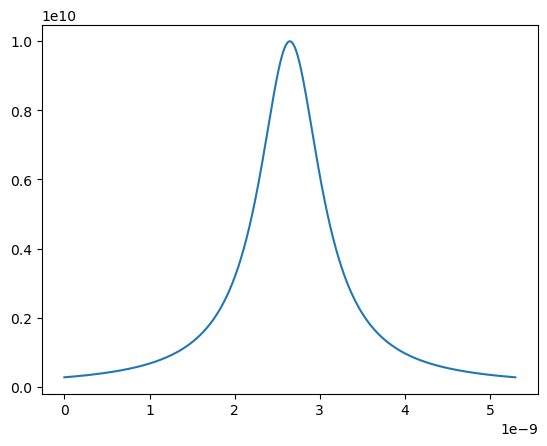

In [32]:
def lorentzian(t, t0, tau, A):
    return A*tau**2 / ((t-t0)**2+(tau)**2)

plt.plot(t, lorentzian(t, t0, tau, 1e10))
plt.show()

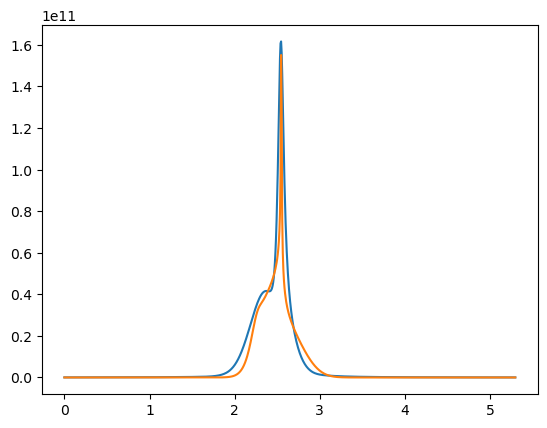

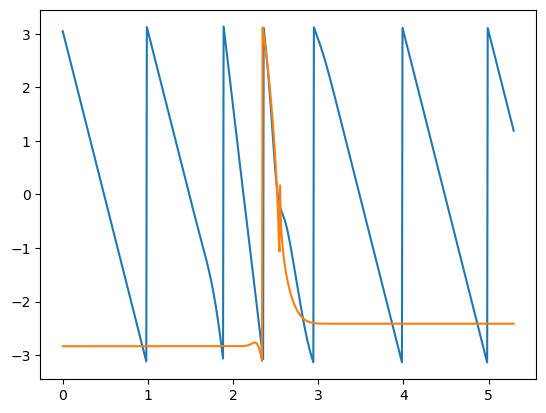

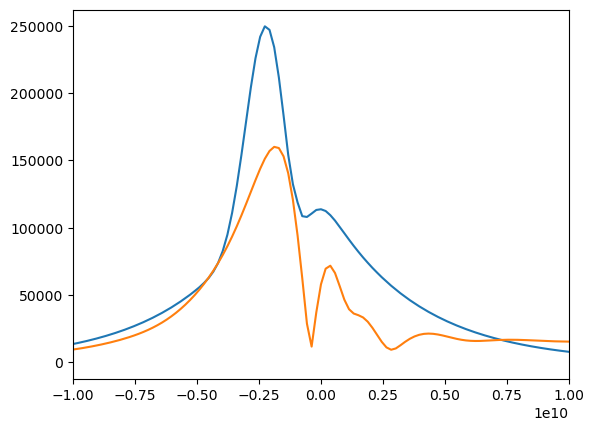

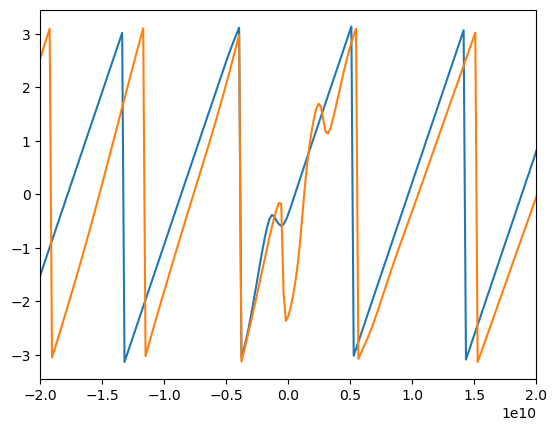

In [33]:
m = 800
t = np.linspace(0, tend, m)

Control = (lorentzian(t, 0.96*t0, 0.1*tau, 15e10)*(25/25)*np.exp(1j*-(2*np.pi*1e9)*(t + 0.95*t0)) 
            + S.gaussian(t, 0.9*t0, tau, 15e10)*(8/25)*np.exp(1j*-(2*np.pi*2e9)*(t + 0.9*t0))
            + S.gaussian(t, 0.95*t0, 0.5*tau, 1e10)*(0/25)*np.exp(1j*(2*np.pi*4.5e9)*(t - 0.95*t0)))[:, None] * control_pol[None, :]

plt.plot(t*1e9, np.abs(Control[:, 0]))
plt.plot(t*1e9, np.abs(Controls[1][0, :, 0]))
plt.show()

plt.plot(t*1e9, np.angle(Control[:, 0]))
plt.plot(t*1e9, np.angle(Controls[1][0, :, 0]))
plt.show()

fControl = np.fft.fft(np.fft.ifftshift(np.array(Control[:, 0]))/sol.gamma)
freq = np.fft.fftfreq(m, d = t[1]-t[0])

freq_shifted = np.fft.fftshift(freq)
fControl_shifted = np.fft.fftshift(fControl)

plt.plot(freq_shifted, np.abs(fControl_shifted))
plt.plot(freq_shifted, np.abs(fControls_shifted[1][0, :, 0]))
plt.xlim(-1e10, 1e10)
plt.show()

plt.plot(freq_shifted, np.angle(fControl_shifted))
plt.plot(freq_shifted, np.angle(fControls_shifted[1][0, :, 0]))
plt.xlim(-2e10, 2e10)
plt.show()

### No adaptive step

In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[1]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Controls[1][0], t=np.linspace(0, tend, len(Controls[0][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[1][1], t=np.linspace(0, tend, len(Controls[0][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 1000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.01

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_storage, Control_inits, step_size, tol,
                                    adaptive_step_size=False)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[1]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Control, t=np.linspace(0, tend, len(Control)) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[1][1], t=np.linspace(0, tend, len(Controls[0][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 1000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.01

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_storage, Control_inits, step_size, tol,
                                    adaptive_step_size=False)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



# Big gaussian? 

In [16]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = 1000
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 1e11)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 5e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 5000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.01

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=False)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=1000, total_eff=0.13527758038123444

Max amps: readin=172362749269.267, readout=75783329329.47264

Total energy: readin=6.574921584216242e-08, readout=3.450839480385803e-08



# Real control field for initial optimium

### No adaptive step

In [4]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = 1000
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = np.array([1000, 5000])

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=False, verbose=False, live_plot=True)
tol = 0.01

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=False)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=1000, total_eff=0.15493479142904315

Max amps: readin=23724997815.710766, readout=15057569651.249

Total energy: readin=4.930457051195779e-09, readout=2.1654426248504286e-08



### Wolfe

In [3]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = 1000
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 1000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=False, verbose=False, live_plot=True)
opt.adapt_method = 'Wolfe'
opt.up_factor = 1.5
opt.down_factor = 0.5
opt.step_tol = 0.01
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

KeyboardInterrupt: 

# Let's look at retrieval efficiency as a function of storage control amplitude

In [10]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = 1000
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Alist = np.linspace(0, 1e11, 40)
storage_eff_list = []
retrieval_eff_list = []

for A in Alist:

    ### storage    
    Sinits_W = np.zeros((n, 1, 1, 1, 1, 1))
    Einits_W = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

    sol_W = S.solver(atom, protocol, Einits_W, Sinits_W, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_W = (S.gaussian(t, t0, tau, A))[:, None] * control_pol[None, :]

    Control_tzp = sol_W.co_prop( Control_W )

    sol_W.solve(Control_tzp, method='RK4-Ralston')

    storage_eff = sol_W.storage_efficiency(sol_W.S, -1)

    ### retrieval
    Sinits_R = sol_W.S[-1]
    Einits_R = np.zeros(m)[:, None] * photon_pol[None, :] 

    sol_R = S.solver(atom, protocol, Einits_R, Sinits_R, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

    Control_R = (S.gaussian(t, t0, tau, 1e10))[:, None] * control_pol[None, :]

    Control_tzp = sol_R.co_prop( Control_R )
    sol_R.solve(Control_tzp, method='RK4-Ralston')

    retrieval_eff = sol_R.retrieval_efficiency(sol_R.E, 0, 0) # retrieval efficiency

    storage_eff_list.append(storage_eff)
    retrieval_eff_list.append(retrieval_eff)

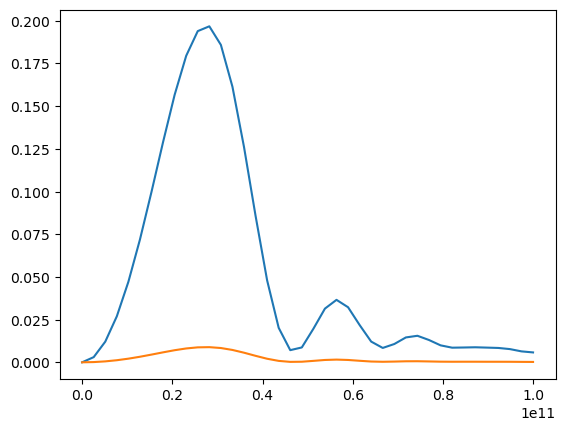

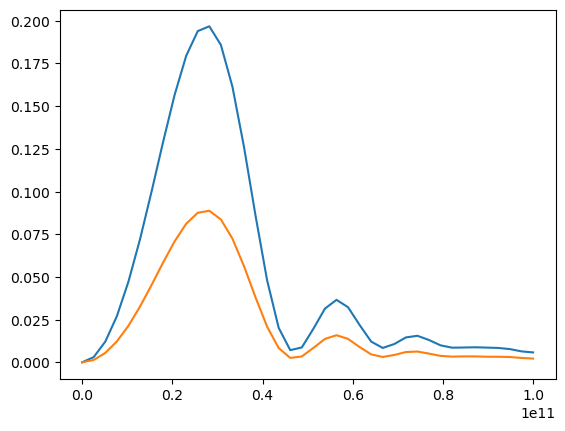

In [14]:
plt.plot(Alist, storage_eff_list)
plt.plot(Alist, np.array(retrieval_eff_list))
plt.show()

plt.plot(Alist, storage_eff_list)
plt.plot(Alist, np.array(retrieval_eff_list)*10)
plt.show()

# Try combining solutions from different plateus

In [16]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### New control field
control_new = Controls[0][0]+Controls[1][0]
energy = np.trapz(np.abs(Controls[0][0][:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
print("OG energy = ", energy)
norm = energy/np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
control_new = control_new*np.sqrt(norm)
print("New energy = ", np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0]))))

### Make optimiser class
Control_init1 = sol.co_prop(control_new, t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[1][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 5000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



OG energy =  392500060982.2257
New energy =  392500060982.22577


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7883746164352116

Max amps: readin=34790330274.42782, readout=89112823776.84143

Total energy: readin=8.268042954300454e-09, readout=5.0281885137822716e-08



In [18]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = sol.co_prop(Controls[0][0], t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 5000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7233703102017438

Max amps: readin=30437580331.57912, readout=64047859012.09236

Total energy: readin=7.085333497961242e-09, readout=2.5118658332326625e-08



### Take different plateua

In [34]:
directory = u'\\\\?\\R:\\home\\MEVeS\\MZ_paper_magic_detuning_(backtrack_bigbig_init)\\'

Raman_file_list = []

start = '_OD='
end = '_L'

OD_list = []

for file in os.listdir(directory):
    if '_MZ_enhanced' not in file:
        Raman_file_list.append(file)
        OD_list.append(float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.')))

In [35]:
ODs = np.array([1000, 3000, 6000])
indices = np.argmin(np.abs(np.array(OD_list)[:, None] - ODs[None, :]), axis=0)
actual_ODs = np.array(OD_list)[indices]
files = np.array(Raman_file_list)[indices]
files

array(['protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=954_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=2947_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6251_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz'],
      dtype='<U207')

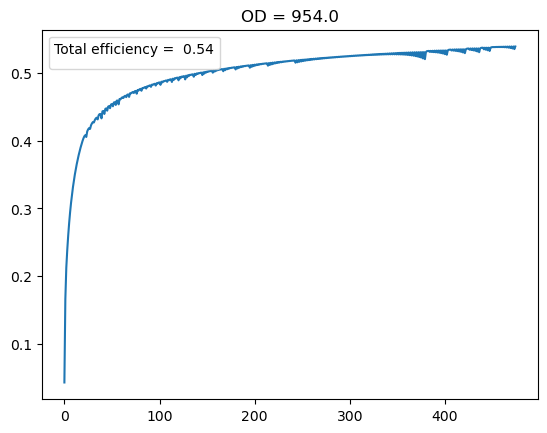

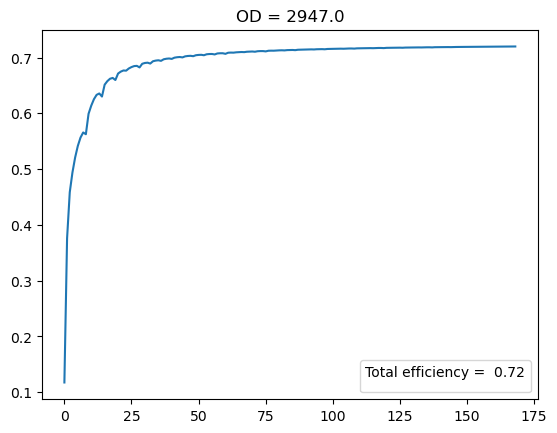

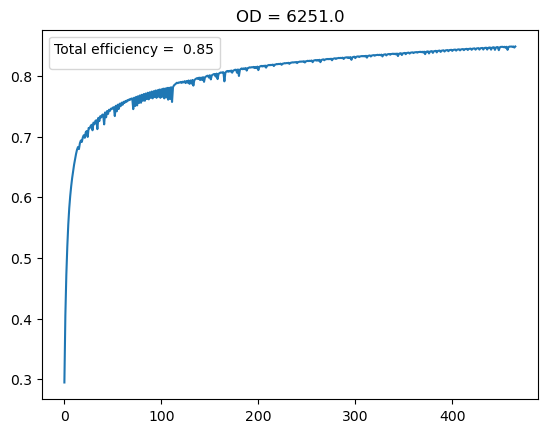

In [36]:
Controls = []
total_effs = []
for i, file in enumerate(files):
    with np.load(directory + file) as data:
        total_eff = data['total_eff_hist'][-1]
        plt.plot(data['total_eff_hist'])
        plt.title('OD = ' + str(actual_ODs[i]))
        plt.legend(handles=[], title=f'Total efficiency = {total_eff: .2f}')
        plt.show()
        total_effs.append(total_eff)
        Control = data['Control_best']
        Controls.append(Control)

In [37]:
start = 'e+00'
end = ']_T'
tend = float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.'))
m = Control.shape[1]
t = np.linspace(0, tend, m)

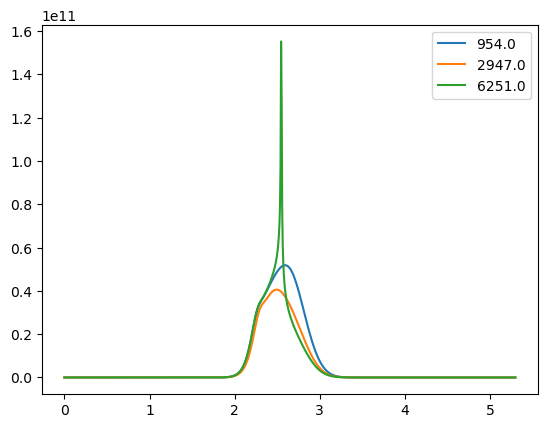

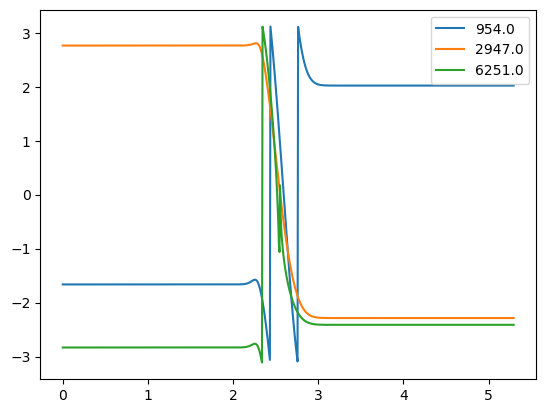

In [38]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.angle(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

In [31]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### New control field
control_new = Controls[0][0]+Controls[1][0]
energy = np.trapz(np.abs(Controls[0][0][:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
print("OG energy = ", energy)
norm = energy/np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
control_new = control_new*np.sqrt(norm)
print("New energy = ", np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0]))))

### Make optimiser class
Control_init1 = sol.co_prop(control_new, t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 5000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



OG energy =  1200947115054.862
New energy =  1200947115054.8625


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=954.0, total_eff=0.5181268453341742

Max amps: readin=47853707886.37826, readout=78778175278.1934

Total energy: readin=1.8846084953344366e-08, readout=4.081394790457293e-08



In [32]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### New control field
control_new = Controls[0][0]+Controls[2][0]
energy = np.trapz(np.abs(Controls[0][0][:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
print("OG energy = ", energy)
norm = energy/np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
control_new = control_new*np.sqrt(norm)
print("New energy = ", np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0]))))

### Make optimiser class
Control_init1 = sol.co_prop(control_new, t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 5000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



OG energy =  1200947115054.862
New energy =  1200947115054.862


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=954.0, total_eff=0.524392149126697

Max amps: readin=51419335633.23209, readout=79337432124.46863

Total energy: readin=1.992087153070417e-08, readout=4.148405146729433e-08



In [33]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 2000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### New control field
control_new = Controls[1][0]+Controls[2][0]
energy = np.trapz(np.abs(Controls[0][0][:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
print("OG energy = ", energy)
norm = energy/np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
control_new = control_new*np.sqrt(norm)
print("New energy = ", np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0]))))

### Make optimiser class
Control_init1 = sol.co_prop(control_new, t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[0][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 5000

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
tol = 0.001

eff, Control_opts, count = opt.Krotov(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



OG energy =  1200947115054.862
New energy =  1200947115054.8623


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

# Momentum

### Take different plateua

In [39]:
directory = u'\\\\?\\R:\\home\\MEVeS\\MZ_paper_magic_detuning_(backtrack_bigbig_init)\\'

Raman_file_list = []

start = '_OD='
end = '_L'

OD_list = []

for file in os.listdir(directory):
    if '_MZ_enhanced' not in file:
        Raman_file_list.append(file)
        OD_list.append(float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.')))

In [40]:
ODs = np.array([5800, 6000, 7000])
indices = np.argmin(np.abs(np.array(OD_list)[:, None] - ODs[None, :]), axis=0)
actual_ODs = np.array(OD_list)[indices]
files = np.array(Raman_file_list)[indices]
files

array(['protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=5690_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6251_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6866_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz'],
      dtype='<U207')

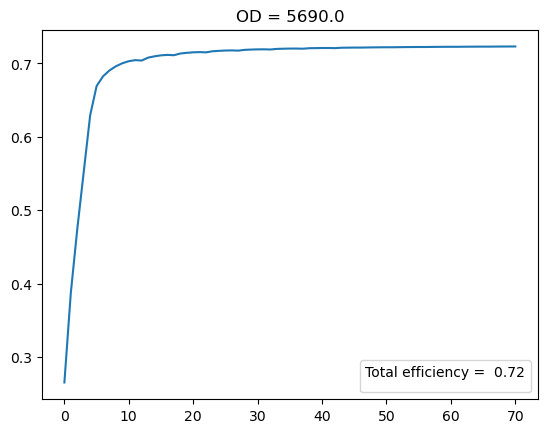

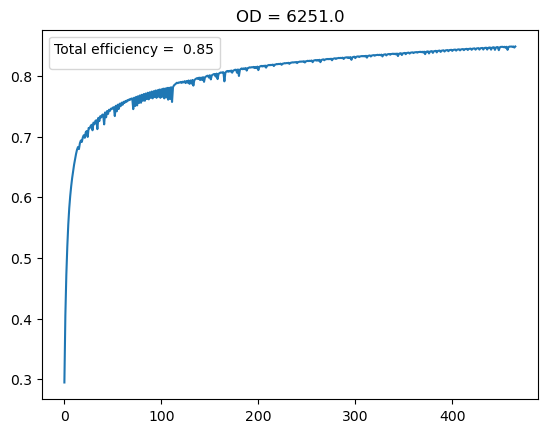

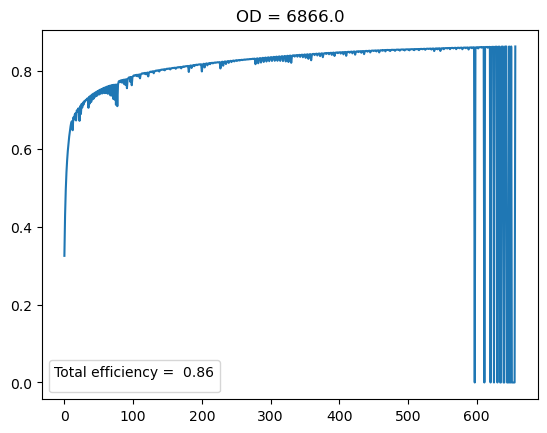

In [41]:
Controls = []
total_effs = []
for i, file in enumerate(files):
    with np.load(directory + file) as data:
        total_eff = data['total_eff_hist'][-1]
        plt.plot(data['total_eff_hist'])
        plt.title('OD = ' + str(actual_ODs[i]))
        plt.legend(handles=[], title=f'Total efficiency = {total_eff: .2f}')
        plt.show()
        total_effs.append(total_eff)
        Control = data['Control_best']
        Controls.append(Control)

In [42]:
start = 'e+00'
end = ']_T'
tend = float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.'))
m = Control.shape[1]
t = np.linspace(0, tend, m)

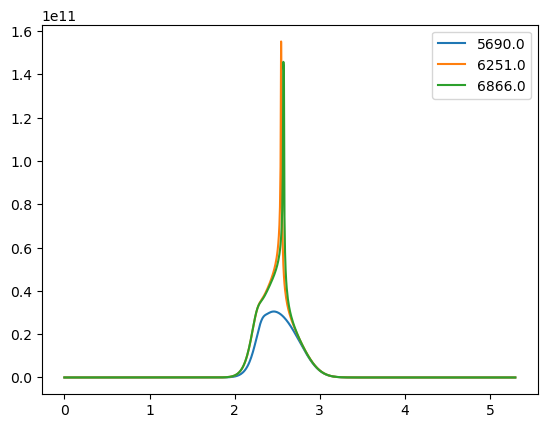

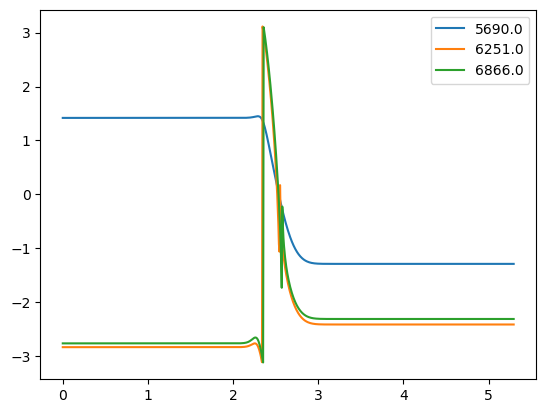

In [43]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.angle(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

### Run opt (turn off stopping condition -> run for 100 iterations)

In [23]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7146246468071643

Max amps: readin=29287209736.67167, readout=15343261713.176805

Total energy: readin=6.206470217364479e-09, readout=2.2322003712198878e-08



In [24]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 400

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7136048460587857

Max amps: readin=30978897831.04227, readout=15979144536.694424

Total energy: readin=6.8673906470020485e-09, readout=2.4195363944472612e-08



In [25]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6
opt.beta1 = 0.95

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.715844747999839

Max amps: readin=29646712470.950672, readout=15630907817.090061

Total energy: readin=6.376975362532031e-09, readout=2.316366758430077e-08



In [26]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 400

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6
opt.beta1 = 0.95

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7110881269702785

Max amps: readin=31202542360.725872, readout=16015126216.799955

Total energy: readin=6.522282329151659e-09, readout=2.431839763400805e-08



In [27]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6
opt.beta1 = 0.99

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7163153285924087

Max amps: readin=29563262214.133118, readout=15731402920.913021

Total energy: readin=6.2117338461788995e-09, readout=2.346365978377566e-08



In [28]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_init2 = np.full(m, 2*np.pi*1e8)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 600

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6
opt.beta1 = 0.99

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.41749877423243265

Max amps: readin=41537911699.12936, readout=16930691601.135822

Total energy: readin=1.162226572871838e-08, readout=2.7184589247508288e-08



### Gaussian initial condition

In [29]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 1e8)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 5e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6
opt.beta1 = 0.95

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7174373405117148

Max amps: readin=29739257068.291924, readout=63152759981.979706

Total energy: readin=6.32242275925395e-09, readout=2.4046589064185276e-08



In [33]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 1e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 5e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 70
tol = 1e-6
opt.beta1 = 0.95

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7171410351345542

Max amps: readin=29602838913.610847, readout=63113105950.17383

Total energy: readin=6.206844313478661e-09, readout=2.4011780368905645e-08



In [34]:
import Optimiser as Opt
importlib.reload(Opt)

### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 1e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 5e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7205690620820837

Max amps: readin=30077952224.66223, readout=63504490901.76621

Total energy: readin=6.5979635319381645e-09, readout=2.438966739038031e-08



### Combine different optima

In [39]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 1000
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### New control field
control_new = Controls[0][0]+Controls[1][0]
energy = np.trapz(np.abs(Controls[0][0][:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
print("OG energy = ", energy)
norm = energy/np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0])))
control_new = control_new*np.sqrt(norm)
print("New energy = ", np.trapz(np.abs(control_new[:, 0])**2, x=np.linspace(0, tend, len(Controls[1][0, :, 0]))))

### Make optimiser class
Control_init1 = sol.co_prop(control_new, t=np.linspace(0, tend, len(Controls[1][0, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_init2 = sol.co_prop(Controls[1][1], t=np.linspace(0, tend, len(Controls[1][1, :, 0])) )(sol.tpoints, 0) * sol.gamma
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 300
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



OG energy =  392500060982.2257
New energy =  392500060982.22577


    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7902071134114232

Max amps: readin=33678339066.48271, readout=92113618749.96608

Total energy: readin=8.46976041635411e-09, readout=5.391039612451752e-08



### How close to we need to start?

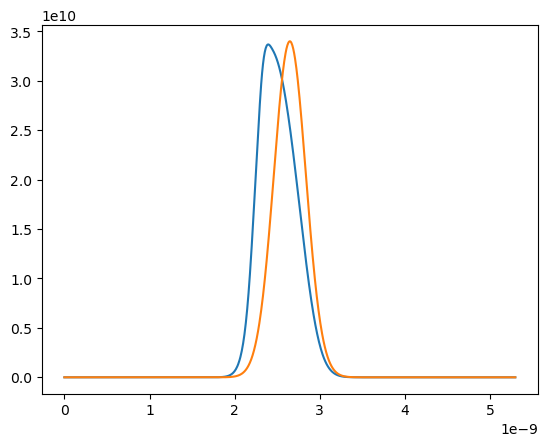

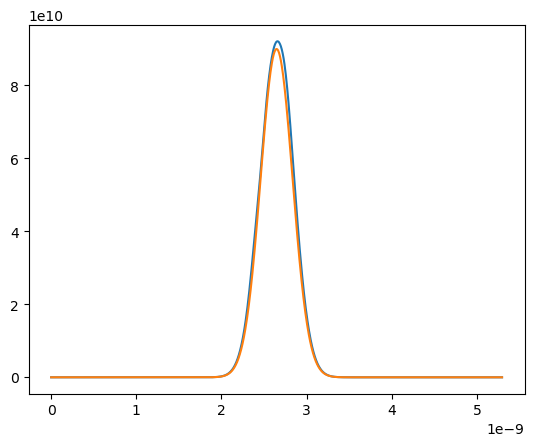

In [47]:
plt.plot(t, np.abs(Control_opts[0, :, 0]))
plt.plot(t, S.gaussian(t, t0, tau, 3.4e10))
plt.show()

plt.plot(t, np.abs(Control_opts[1, :, 0]))
plt.plot(t, S.gaussian(t, t0, tau, 9e10))
plt.show()

In [48]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 3.4e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 9e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=5690.0, total_eff=0.7845012987256235

Max amps: readin=31412925407.470024, readout=94207806208.73486

Total energy: readin=7.199085196722022e-09, readout=5.32415975938671e-08



## Other plateau

In [4]:
directory = u'\\\\?\\R:\\home\\MEVeS\\MZ_paper_magic_detuning_(backtrack_bigbig_init)\\'

Raman_file_list = []

start = '_OD='
end = '_L'

OD_list = []

for file in os.listdir(directory):
    if '_MZ_enhanced' not in file:
        Raman_file_list.append(file)
        OD_list.append(float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.')))

In [5]:
ODs = np.array([1000, 3000, 6000])
indices = np.argmin(np.abs(np.array(OD_list)[:, None] - ODs[None, :]), axis=0)
actual_ODs = np.array(OD_list)[indices]
files = np.array(Raman_file_list)[indices]
files

array(['protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=954_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=2947_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz',
       'protocol=Raman_config=Rb87_5s1q2F[0]_5p3q2_5s1q2F[0]_HyperfineSplittingNo_deltas=[18600d0MHz, 18600d0MHz]_OD=6251_L=0d075_n=50_m=800_tbounds=[0d0000000e+00 5d2952544e-09]_T=0_vno=1_gaussian_input_photon.npz'],
      dtype='<U207')

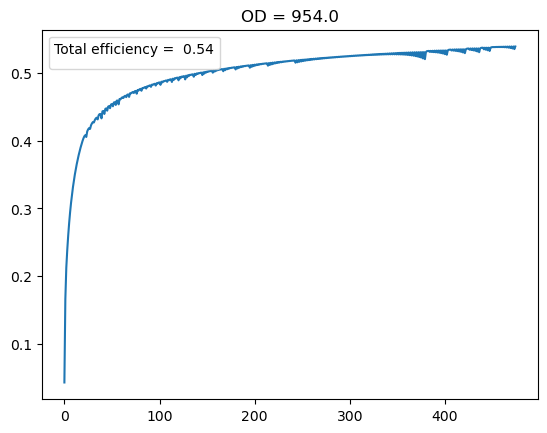

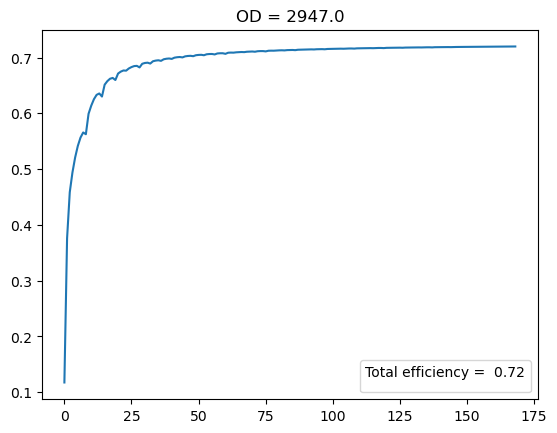

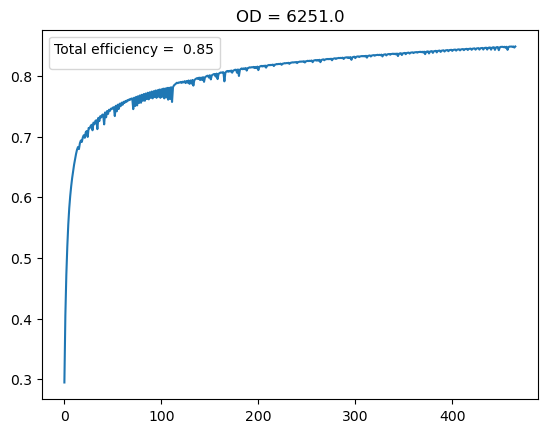

In [6]:
Controls = []
total_effs = []
for i, file in enumerate(files):
    with np.load(directory + file) as data:
        total_eff = data['total_eff_hist'][-1]
        plt.plot(data['total_eff_hist'])
        plt.title('OD = ' + str(actual_ODs[i]))
        plt.legend(handles=[], title=f'Total efficiency = {total_eff: .2f}')
        plt.show()
        total_effs.append(total_eff)
        Control = data['Control_best']
        Controls.append(Control)

In [7]:
start = 'e+00'
end = ']_T'
tend = float((file[file.find(start)+len(start):file.rfind(end)]).replace('d', '.'))
m = Control.shape[1]
t = np.linspace(0, tend, m)

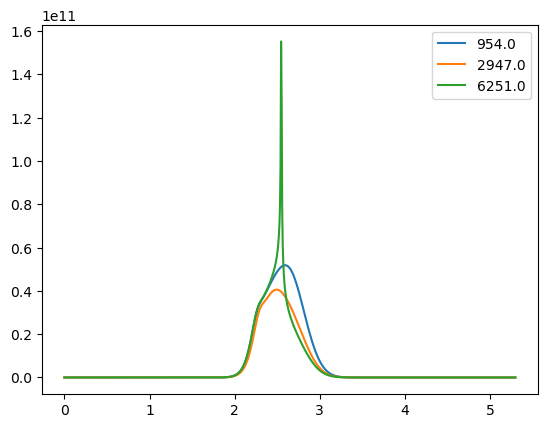

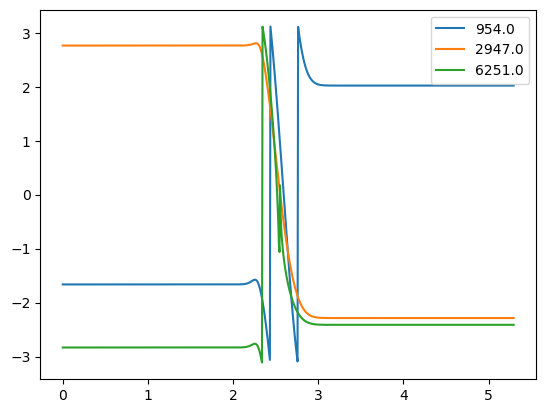

In [8]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.angle(Controls[i][0, :, 0]), label=OD)

plt.legend()
plt.show()

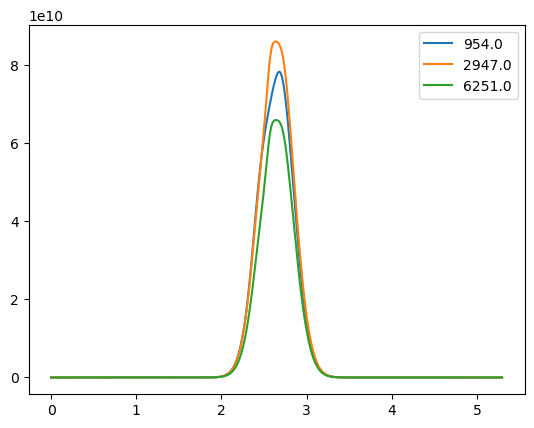

In [9]:
for i, OD in enumerate(actual_ODs):
    plt.plot(t*1e9, np.abs(Controls[i][1, :, 0]), label=OD)

plt.legend()
plt.show()

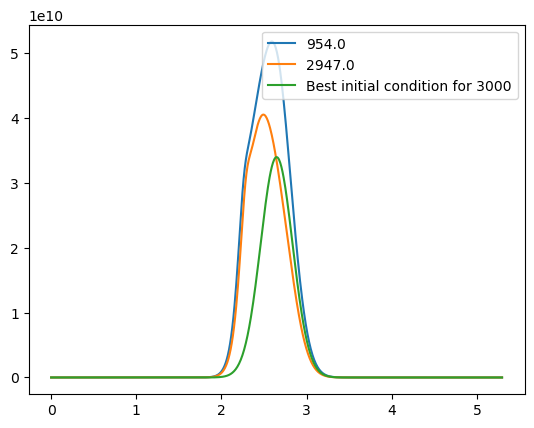

In [10]:
plt.plot(t*1e9, np.abs(Controls[0][0, :, 0]), label=actual_ODs[0])
plt.plot(t*1e9, np.abs(Controls[1][0, :, 0]), label=actual_ODs[1])
plt.plot(t*1e9, S.gaussian(t, t0, tau, 3.4e10), label='Best initial condition for 3000')

plt.legend()
plt.show()

In [11]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 3.4e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 9e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 500
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=954.0, total_eff=0.5411909694672965

Max amps: readin=48905771887.23013, readout=126671482927.31862

Total energy: readin=1.8586360201645415e-08, readout=1.0210318535996561e-07



In [14]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n": 5, "L":0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = Control_opts[0]
Control_init2 = Control_opts[1]
Control_inits = [Control_init1, Control_init2]
step_size = 200

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 500
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")



    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=954.0, total_eff=0.6349403693185605

Max amps: readin=54314264930.9353, readout=132655273717.85944

Total energy: readin=2.4437177687256877e-08, readout=1.3012587654374738e-07



In [ ]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"L": 0, "F" : 1}}}
atom = A.Rb87(config)

### Make solver class
protocol = 'Raman'
OD = actual_ODs[0]
BW = 2*np.pi*1e9
tau = 2*np.log(2)/(np.pi*(BW/(2*np.pi)))
m = 800
n = 50
T = 0
vno = 1
detuning = 2*np.pi*18.6e9

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

L = 0.075

t0 = 6*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno))

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 3.4e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 9e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 500
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

